In [ ]:
pip install transformers datasets librosa torch ipywidgets huggingface_hub

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import os
import pandas as pd

# Thư mục chứa dữ liệu âm thanh
base_dir = '/content/drive/MyDrive/newdata'

# Danh sách các vùng miền
regions = ["Bac", "Trung", "Nam"]

# Danh sách để lưu thông tin
data = []

# Duyệt qua từng vùng miền và tệp âm thanh
for region in regions:
    region_dir = os.path.join(base_dir, region)
    for file_name in os.listdir(region_dir):
        if file_name.endswith('.wav'):
            file_path = os.path.join(region_dir, file_name)
            data.append({'filepath': file_path, 'label': region})

# Chuyển dữ liệu thành DataFrame
df = pd.DataFrame(data)

In [ ]:
from datasets import Dataset, DatasetDict, Audio, ClassLabel

# Danh sách các nhãn (label) có thể có
label_names = ["Bac", "Trung", "Nam"]

# Chuyển đổi nhãn thành chỉ số (index)
df['label'] = df['label'].apply(lambda x: label_names.index(x))

# Chuyển đổi DataFrame thành Dictionary và tạo Dataset
data_dict = {
    'file': df['filepath'].tolist(),
    'audio': [{'path': filepath} for filepath in df['filepath']],
    'label': df['label'].tolist()
}

# Tạo Dataset từ Dictionary
dataset = Dataset.from_dict(data_dict)

# Thêm thông tin về các lớp (class label)
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
dataset = dataset.cast_column("label", ClassLabel(names=label_names))

# Chia tập dữ liệu
train_testvalid = dataset.train_test_split(test_size=0.3, shuffle=True, seed=42)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5, shuffle=True, seed=42)
split_dataset = DatasetDict({
    'train': train_testvalid['train'],
    'validation': test_valid['train'],
    'test': test_valid['test']
})

print(split_dataset)

Casting the dataset:   0%|          | 0/4946 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'label'],
        num_rows: 3462
    })
    validation: Dataset({
        features: ['file', 'audio', 'label'],
        num_rows: 742
    })
    test: Dataset({
        features: ['file', 'audio', 'label'],
        num_rows: 742
    })
})


In [ ]:
from transformers import AutoFeatureExtractor

model_checkpoint = "facebook/wav2vec2-base"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)

max_duration = 20.0  # seconds

def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
    )
    inputs["labels"] = examples["label"]
    return inputs

encoded_dataset = split_dataset.map(preprocess_function, remove_columns=["audio", "file"], batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Map:   0%|          | 0/3462 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

num_labels = len(label_names)
model = AutoModelForAudioClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
)

training_args = TrainingArguments(
    output_dir=f"{model_checkpoint.split('/')[-1]}-finetuned-ks",
    eval_strategy="epoch",  # Thay đổi từ evaluation_strategy
    save_strategy="epoch",
    learning_rate=3e-5, # tốc độ học 3e-5
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,  # Không đẩy lên Hugging Face Hub
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=1)
    accuracy = (predictions == labels).mean()
    return {"accuracy": accuracy}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.evaluate()
trainer.save_model("Model")

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
0,0.575400,0.432525,0.834232
2,0.305900,0.529071,0.809973
4,0.207500,0.344937,0.888140


In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def collate_fn(batch):
    audios = [torch.tensor(item["audio"]["array"]) for item in batch]
    labels = [item["label"] for item in batch]
    padded_audios = pad_sequence(audios, batch_first=True)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    return {"audio": padded_audios, "label": labels_tensor}

test_dataloader = DataLoader(
    split_dataset["test"],
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.eval()
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for batch in test_dataloader:
        inputs = batch["audio"].float().to(device)
        labels = batch["label"].to(device)
        outputs = model(inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
        _, predicted = torch.max(probabilities, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

accuracy = correct_predictions / total_predictions
print(f"Accuracy on test set: {accuracy}")

Accuracy on test set: 0.8827493261455526


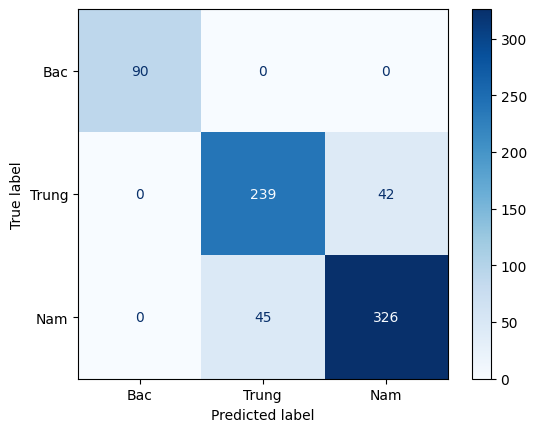

In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def collate_fn(batch):
    audios = [torch.tensor(item["audio"]["array"]) for item in batch]
    labels = [item["label"] for item in batch]
    padded_audios = pad_sequence(audios, batch_first=True)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    return {"audio": padded_audios, "label": labels_tensor}

test_dataloader = DataLoader(
    split_dataset["test"],
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        inputs = batch["audio"].float().to(device)
        labels = batch["label"].to(device)
        outputs = model(inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
        _, predicted = torch.max(probabilities, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Tính toán ma trận hỗn loạn
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()


# Kết quả cho thấy rằng mô hình có độ chính xác khá cao. Đây là những điểm nổi bật từ ma trận hỗn loạn của:

- Bắc:
  Đúng: 90
  Sai: 0
- Trung:
  Đúng: 236
  Sai (được dự đoán là Nam): 45
- Nam:
  Đúng: 336
  Sai (được dự đoán là Trung): 35

#Để cải thiện kết quả của mô hình,có thể thử các bước sau:

- Tăng số lượng dữ liệu huấn luyện: Cung cấp thêm dữ liệu huấn luyện để mô hình học tốt hơn các đặc điểm phân biệt giữa các lớp.
- Tăng số epoch huấn luyện: Huấn luyện mô hình trong thời gian dài hơn có thể giúp mô hình học tốt hơn.
- Tối ưu hóa siêu tham số: Sử dụng các kỹ thuật tối ưu hóa siêu tham số như Grid Search hoặc Random Search để tìm kiếm các tham số tối ưu cho mô hình.
- Sử dụng kỹ thuật augmentation: Thực hiện augmentation trên dữ liệu âm thanh để tăng tính đa dạng của dữ liệu.